In [5]:
%gui qt5
%matplotlib qt5

import imp as reload_tool
import re
import os
import sh
import pandas as pd

import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm       as cm
import matplotlib          as mpl
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import numpy as np
import scipy.signal as scysig
import pycolleff.impedances as imp
import pycolleff.sirius as si
import pycolleff.colleff as colleff
import pycolleff.process_wakes as ems
import cppcolleff as cppcolef
import pyaccel
import pymodels as sirius

from IPython.display import Latex
from IPython.display import SVG

rcParams.update({'font.size': 22,'lines.linewidth':2, 'axes.grid': True})

# Study of Collective Effects for Sirius

First we load the appropriate model of the ring:

In [6]:
## Functions Definitions:
fsz = 26
rcParams.update({'font.size': fsz,'lines.linewidth':2})

#Definition of default colormap function:
default_cm = lambda x: cm.brg(np.linspace(0,1,x+1 if isinstance(x,int) else len(x)+1))
# default_cm = lambda x: cm.nipy_spectral(np.linspace(0,1,x+1 if isinstance(x,int) else len(x)+1))

In [7]:
ring = si.create_ring(phase=1)
ring.nom_cur = 40e-3
print(ring)

Lattice Version             : SI.v20.01-s05.02.Phase1
Circumference [m]           :       518.396       
Revolution Period [us]      :        1.729        
Revolution Frequency [kHz]  :       578.3078      
Energy [GeV]                :         3.0         
Momentum Compaction         :       1.70e-04      
Harmonic Number             :         864         
Current [mA]                :         40.0        
Current per Bunch [mA]      :        0.046        
Synchrotron Tune            :      4.600e-03      
Tunes x/y                   :    49.110/14.170    
Damping Times x/y/e [ms]    :   12.4/ 15.1 /8.5   
Energy Spread               :       8.94e-04      
Bunch Length [mm]           :       2.48e+00      



In [17]:
wr = np.array([
    500, 501, 502, 503, 505, 507, 508,
    712, 716, 722, 728, 733, 738, 739, 1130, 1140, 1150,
    1170, 1250, 1260, 1270, 1369.88, 1369.94, 1370.95,
    1386.3, 1386.9, 1387.5, 1387.3, 1388.1, 1389.7]) * 2 * np.pi * 1e6 #* 499.5/500
Rs = np.array([
    31.6, 0.0053, 0.0575, 0.0006, 0.0017, 0.0001, 0.0001,
    0.0091, 0.0124, 1.13, 3, 0.7245, 0.479, 0.457, 0.0002,
    0.0008, 0.0006, 0.025, 0.067, 0.155, 0.01, 0.6, 0.5,
    1.14, 1.1, 0.3, 1.8, 1.3, 0.2, 0.1]) * 1e6
Q = np.array([
    36900, 37500, 38100, 38800, 39800, 40800, 41400,
    30300, 31100, 32300, 33600, 35000, 35500, 36000,
    34300, 35500, 37100, 38900, 55100, 55200, 49500,
    39600, 39600, 39750, 39900, 39950, 39960, 40000,
    40000, 40000])

p = np.arange(0,900)*ring.w0
ph = np.arange(0,2)*ring.w0*ring.nbun
w = np.linspace(490, 1510, 100000) * 1e6*2*np.pi
w = np.hstack([-np.flipud(w), w])
Zl = imp.longitudinal_resonator(w=w, wr=wr, Rs=Rs, Q=Q)
# fig = plt.figure()
# plt.plot(w/2/np.pi*1e-9, Zl.real*1e-6)
# plt.plot(p/2/np.pi*1e-9, 0*p,'.')
# plt.plot(ph/2/np.pi*1e-9, 0*ph,'.')
# fig.show()

In [18]:
nb = ring.nbun
w0 = ring.w0
nus = ring.nus()
pmin = np.ceil( (w[ 0] -    1*nus*w0    )/(w0*nb))
pmax = np.floor((w[-1] - (nb-1+1*nus)*w0)/(w0*nb))
print(w[0]/2/np.pi, w[-1]/2/np.pi, pmin, pmax)

-1510000000.0 1510000000.0 -3.0 2.0


In [19]:
Rs = np.array([28.1, ]) * 1e6
Q = np.array([11000, ])*1
w = np.linspace(490, 1500, 100000) * 1e6*2*np.pi
w = np.hstack([-np.flipud(w), w])

dfreq = np.linspace(-20, 20, 100)*1e3
d1 = []
for df in dfreq:
    wr = ring.w0 * 864 + 2*np.pi * df
    Zl = imp.longitudinal_resonator(w=w, wr=wr, Rs=Rs, Q=Q)
    deltap1 = ring.longitudinal_cbi(w=w, Zl=Zl, bunlen=2.5e-3, m=1)
    id1 = 0  # np.argmax(np.abs(deltap1.imag))
    d1.append(deltap1[id1])

d1 = np.array(d1)

fig = plt.figure(figsize=(7,4.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.2, right=0.98, top=0.98, bottom=0.18, hspace=0.10)
ax1 = plt.subplot(gs[0,0])

ax1.plot(dfreq/1e3, d1.imag*1e3, '.', label='m=1')
ax1.legend()
ax1.set_ylabel('growth rate [mHz]')
ax1.set_xlabel(r'$\Delta f$ [kHz]')
fig.show()

In [22]:
fig = plt.figure(figsize=(11,4))
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.11,right=0.79,top=0.96,bottom=0.2, wspace=0.23, hspace=0.10)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1], sharey=ax1)

ax1.semilogy(w/2/np.pi/1e9,Zl.real*1e-6, 'k')
ax2.semilogy(w/2/np.pi/1e9,Zl.real*1e-6, 'k')
plt.setp(ax2.get_yticklabels(),visible=False)

ring = si.create_ring(phase=1)
ring.nus = 3.6e-3
curr = [0.1, 0.05, 0.025, 0.01, 0.005]
labels = ['100 mA', '50 mA', '25 mA', '10 mA', '5 mA']
colors = default_cm(len(curr))
Z = []
for cu, lab, c in zip(curr,labels, colors):
    ring.nom_cur = cu
    Z.append(ring.longitudinal_cbi(w=w, Zl=Zl, bunlen=3.2e-3, m=1, inverse=True))
    ax1.semilogy(w/2/np.pi/1e9,Z[-1]*1e-6, color=c, label=lab)
    ax2.semilogy(w/2/np.pi/1e9,Z[-1]*1e-6, color=c, label=lab)

    
def format_axis(x,y):
    if x>10:
        return '$%1i$' % (x)
    if x>=0.09:
        return '$%.1f$' % (x)
    else:
        return '$%.2f$' % (x)
    
formatter = plt.FuncFormatter(format_axis)
ax1.yaxis.set_major_formatter(formatter)
    
# ax1.set_xlim([.720,.740])
# ax2.set_xlim([1.370,1.390])
# ax1.set_ylim([1e-1,10])
ax1.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('Re$Z_L$ [M$\Omega$]')
ax2.legend(loc='center left', bbox_to_anchor=(1.0,0.5), fontsize=20)
ax1.xaxis.set_label_coords(1.15,-0.15)
plt.show()

fig.savefig('long_cbi_minimum_impedance.png')

In [21]:
fig = plt.figure(figsize=(11,4))
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.11,right=0.79,top=0.96,bottom=0.2, wspace=0.20, hspace=0.10)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1], sharey=ax1)
plt.setp(ax2.get_yticklabels(),visible=False)

ring = si.create_ring(phase=1)
curr = [0.1, 0.05, 0.025, 0.01, 0.005]
labels = ['100 mA', '50 mA', '25 mA', '10 mA', '5 mA']
colors = default_cm(len(curr))
Z = []
for cu, lab, c in zip(curr,labels, colors):
    ring.nom_cur = cu
    Zs = ring.longitudinal_cbi(w=wr, Zl=Zl, bunlen=2.5e-3, m=1, inverse=True)
    indcs = Rs >= Zs
    wr2 = wr[indcs]
    Rs2 = Rs[indcs]
    Q2 = Q[indcs]
    Zs2 = Zs[indcs]
    
    f = np.sqrt(Rs2/Zs2-1)/Q2
    deltap = f/2 + np.sqrt(f**2/2**2 +1)
    deltan = -f/2 + np.sqrt(f**2/2**2 +1)
    delfp = deltap*wr2/ring.w0
    delfn = deltan*wr2/ring.w0
    delnup = delfp - np.floor(wr2/ring.w0)
    delnun = delfn - np.floor(wr2/ring.w0)

    mu = np.remainder(np.floor(wr2/ring.w0), ring.nbun)

    ax1.plot([mu, mu], [delnup, delnun], color=c)
    ax1.plot(mu, delnup, 'r.' , markersize=10, color=c)
    ax1.plot(mu, delnun, 'r.', markersize=10, color=c, label=lab)
    ax2.plot([mu, mu], [delnup, delnun], color=c)
    ax2.plot(mu, delnup, 'r.' , markersize=10, color=c)
    ax2.plot(mu, delnun, 'r.', markersize=10, color=c, label=lab)

ax1.plot([0,864], np.ones(2)-0.004, 'k')
ax1.plot([0,864], np.zeros(2)+0.004, 'k')
ax2.plot([0,864], np.ones(2)-0.004, 'k')
ax2.plot([0,864], np.zeros(2)+0.004, 'k')
ax1.set_ylim([0,1])
ax1.set_xlim([380,420])
ax2.set_xlim([635,675])
ax1.grid(True)
ax2.grid(True)
ax1.set_xlabel('Coupled Bunch Mode ($\mu_R$)')
ax1.set_ylabel(r'$\Delta\nu_\parallel$')
ax2.legend(loc='center left', bbox_to_anchor=(1.0,0.5), fontsize=20)
ax1.xaxis.set_label_coords(1.15,-0.15)
plt.show()

fig.savefig('long_cbi_frac_frequencies.png')

IndexError: invalid index to scalar variable.

<IPython.core.display.Javascript object>


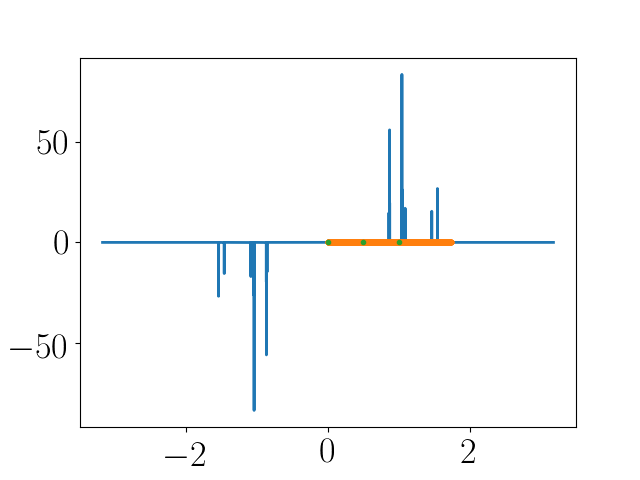

In [13]:
wr = np.array([860.17, 867.04, 869.47, 870.88, 1043.41,
               1047.32, 1089.00, 1464.92, 1545.11])* 2*np.pi *1e6

Rs = np.array([14.7, 17.5, 56.1, 19.7, 83.6,
               26.2, 17.0, 15.5, 26.8]) * 1e6

Q = np.array([55700, 56800, 58200, 59400, 40400,
              40900, 49400, 54600, 44300])


ring = si.create_ring(phase=1)

p = np.arange(0,3000)*ring.w0
ph = np.arange(0,3)*ring.w0*ring.nbun
w = np.linspace(850,1560, 1000000) * 1e6*2*np.pi
w = np.hstack([-20e9,-np.flipud(w), w, 20e9])
Zt = imp.transverse_resonator(w=w, wr=wr, Rs=Rs, Q=Q)
plt.figure()
plt.plot(w/2/np.pi*1e-9, Zt.real*1e-6)
plt.plot(p/2/np.pi*1e-9, 0*p,'.')
plt.plot(ph/2/np.pi*1e-9, 0*ph,'.')

plt.show()

<IPython.core.display.Javascript object>


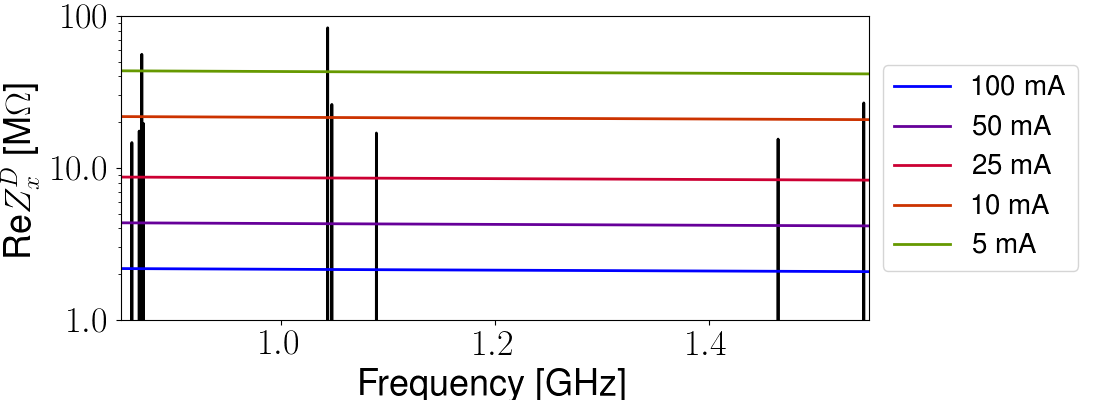

In [24]:
fig = plt.figure(figsize=(11,4))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.11,right=0.79,top=0.96,bottom=0.2, wspace=0.23, hspace=0.10)
ax1 = plt.subplot(gs[0,0])

ax1.semilogy(w/2/np.pi/1e9,Zt.real*1e-6, 'k')

ring = si.create_ring(phase=1)
ring.chromx = 2.5
ring.nus = 3.6e-3
curr = [0.1, 0.05, 0.025, 0.01, 0.005]
labels = ['100 mA', '50 mA', '25 mA', '10 mA', '5 mA']
colors = default_cm(len(curr))
betat = 5.0
for cu, lab, c in zip(curr,labels, colors):
    ring.nom_cur = cu
    Z = ring.transverse_cbi(w=w, Zt=Zt, bunlen=3.2e-3, m=0, inverse=True, plane='x')/betat
    ax1.semilogy(w/2/np.pi/1e9,Z*1e-6, color=c, label=lab)
    
def format_axis(x,y):
    if x>10:
        return '$%1i$' % (x)
    if x>=0.09:
        return '$%.1f$' % (x)
    else:
        return '$%.2f$' % (x)
    
formatter = plt.FuncFormatter(format_axis)
ax1.yaxis.set_major_formatter(formatter)
    
ax1.set_xlim([.850,1.550])
ax1.set_ylim([1,100])
ax1.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('Re$Z_x^D$ [M$\Omega$]')
ax1.legend(loc='center left', bbox_to_anchor=(1.0,0.5), fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


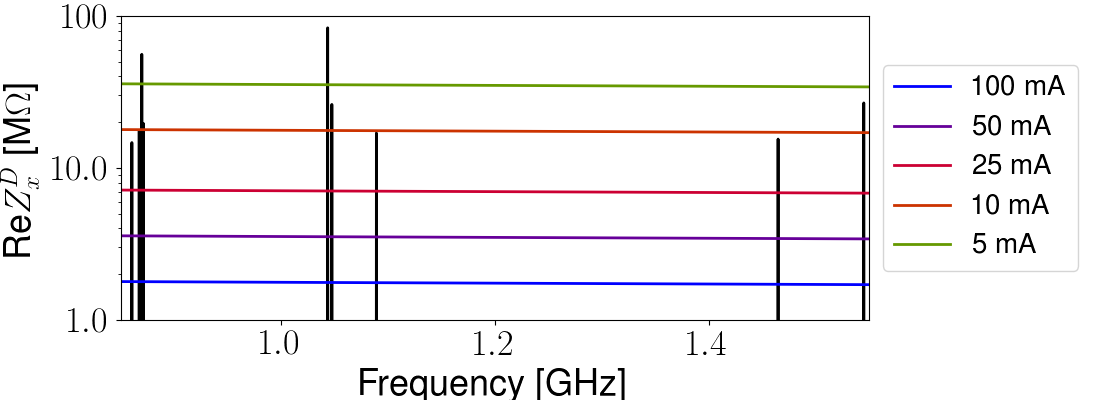

In [25]:
fig = plt.figure(figsize=(11,4))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.11,right=0.79,top=0.96,bottom=0.2, wspace=0.23, hspace=0.10)
ax1 = plt.subplot(gs[0,0])

ax1.semilogy(w/2/np.pi/1e9,Zt.real*1e-6, 'k')

ring = si.create_ring(phase=1)
ring.chromx = 0
ring.nus = 3.6e-3
curr = [0.1, 0.05, 0.025, 0.01, 0.005]
labels = ['100 mA', '50 mA', '25 mA', '10 mA', '5 mA']
colors = default_cm(len(curr))
betat = 5.0
for cu, lab, c in zip(curr,labels, colors):
    ring.nom_cur = cu
    Z = ring.transverse_cbi(w=w, Zt=Zt, bunlen=3.2e-3, m=0, inverse=True)/betat
    ax1.semilogy(w/2/np.pi/1e9,Z*1e-6, color=c, label=lab)
    
def format_axis(x,y):
    if x>10:
        return '$%1i$' % (x)
    if x>=0.09:
        return '$%.1f$' % (x)
    else:
        return '$%.2f$' % (x)
    
formatter = plt.FuncFormatter(format_axis)
ax1.yaxis.set_major_formatter(formatter)
    
ax1.set_xlim([.850,1.550])
ax1.set_ylim([1,100])
ax1.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('Re$Z_x^D$ [M$\Omega$]')
ax1.legend(loc='center left', bbox_to_anchor=(1.0,0.5), fontsize=20)
plt.show()

fig.savefig('trans_cbi_minimum_impedance.png')

<IPython.core.display.Javascript object>


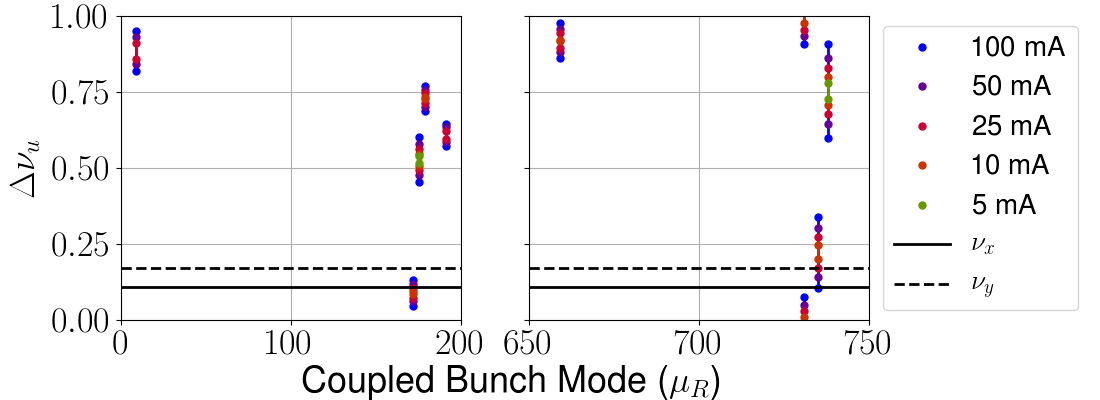

In [57]:
fig = plt.figure(figsize=(11,4))
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.11,right=0.79,top=0.96,bottom=0.2, wspace=0.20, hspace=0.10)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1], sharey=ax1)
plt.setp(ax2.get_yticklabels(),visible=False)

ring = si.create_ring(phase=1)
ring.chromy = 0
ring.chromx = 0
curr = [0.1, 0.05, 0.025, 0.01, 0.005]
labels = ['100 mA', '50 mA', '25 mA', '10 mA', '5 mA']
colors = default_cm(len(curr))
for cu, lab, c in zip(curr,labels, colors):
    ring.nom_cur = cu
    Zs = ring.transverse_cbi(w=wr, Zt=Zt, bunlen=3.2e-3, m=0, inverse=True, plane='x')/betat
    indcs = Rs >= Zs
    wr2 = wr[indcs]
    Rs2 = Rs[indcs]
    Q2 = Q[indcs]
    Zs2 = Zs[indcs]
    
    deltap = np.zeros(len(Q2))
    deltan = np.zeros(len(Q2))
    for i in range(len(Q2)):
        rs = np.roots([1,0,1/Q2[i]**2-2,Rs2[i]/Zs2[i]/Q2[i]**2,1])
        rs = rs[rs<0].real
        deltap[i] = max(rs)
        deltan[i] = min(rs)
    delfp = deltap*wr2/ring.w0
    delfn = deltan*wr2/ring.w0
    delnup = delfp - np.floor(delfp)
    delnun = delfn - np.floor(delfn)

    mu = np.remainder(np.floor(-wr2/ring.w0-ring.nux), ring.nbun)
    ind = delnup > delnun
    nind = np.logical_not(ind)
    ax1.plot([mu[ind], mu[ind]], [delnup[ind], delnun[ind]], color=c)
    ax1.plot([mu[nind], mu[nind]], [delnup[nind], delnun[nind]*0 + -0.1], color=c)
    ax1.plot([mu[nind], mu[nind]], [delnup[nind]*0 + 1.1, delnun[nind]], color=c)
    ax2.plot([mu[ind], mu[ind]], [delnup[ind], delnun[ind]], color=c)
    ax2.plot([mu[nind], mu[nind]], [delnup[nind], delnun[nind]*0 + -0.1], color=c)
    ax2.plot([mu[nind], mu[nind]], [delnup[nind]*0 + 1.1, delnun[nind]], color=c)
    ax1.plot(mu, delnup, 'r.' , markersize=10, color=c)
    ax1.plot(mu, delnun, 'r.', markersize=10, color=c, label=lab)
    ax2.plot(mu, delnup, 'r.' , markersize=10, color=c)
    ax2.plot(mu, delnun, 'r.', markersize=10, color=c, label=lab)


# ax1.plot([0,864], np.zeros(2) +1 - ring.nux%1, 'k')
ax1.plot([0,864], np.zeros(2)+ ring.nux%1, 'k')
ax2.plot([0,864], np.zeros(2)+ ring.nux%1, 'k', label=r'$\nu_x$')
ax1.plot([0,864], np.zeros(2)+ ring.nuy%1, 'k--')
ax2.plot([0,864], np.zeros(2)+ ring.nuy%1, 'k--', label=r'$\nu_y$')
ax1.set_xlim([0,200])
ax2.set_xlim([650,750])
ax1.set_ylim([0,1])
ax1.grid(True)
ax2.grid(True)
ax1.set_xlabel('Coupled Bunch Mode ($\mu_R$)')
ax1.set_ylabel(r'$\Delta\nu_u$')
ax2.legend(loc='center left', bbox_to_anchor=(1.0,0.5), fontsize=20)
ax1.xaxis.set_label_coords(1.15,-0.17)
plt.show()

fig.savefig('trans_cbi_frac_frequencies.png')

<IPython.core.display.Javascript object>


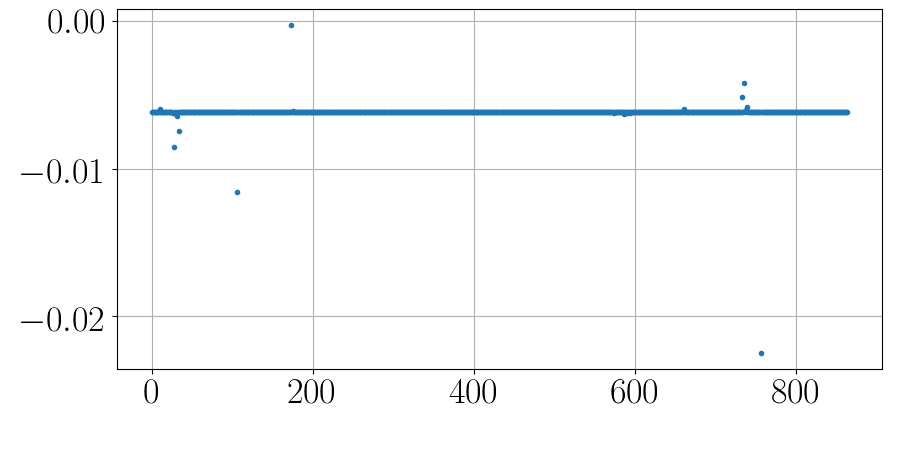

In [59]:
ring = si.create_ring(phase=1)
# ring.nbun = 216
ring.chromx = 0.0
ring.nom_cur=30e-3
ring.nus = 3.6e-3
betat = 5.0
delta = ring.transverse_cbi(w=w, Zt=betat*Zt, bunlen=3.2e-3, m=0, plane='x')

fig = plt.figure(figsize=(9,4.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.13,right=0.98,top=0.98,bottom=0.18, hspace=0.10)
ax1 = plt.subplot(gs[0,0])

ax1.plot(delta.imag, '.')
ax1.grid(True)
plt.show()

<IPython.core.display.Javascript object>


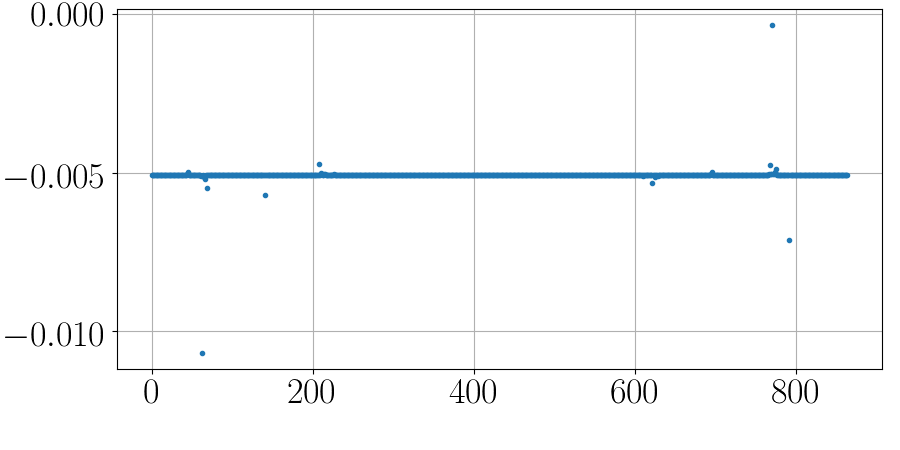

In [60]:
ring = si.create_ring(phase=1)
# ring.nbun = 216
ring.chromx = 0.0
ring.nom_cur=30e-3
ring.nus = 3.6e-3
betat = 5.0
delta = ring.transverse_cbi(w=w, Zt=betat*Zt, bunlen=3.2e-3, m=0, plane='y')

fig = plt.figure(figsize=(9,4.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.13,right=0.98,top=0.98,bottom=0.18, hspace=0.10)
ax1 = plt.subplot(gs[0,0])

ax1.plot(delta.imag, '.')
ax1.grid(True)
plt.show()

In [58]:
ring.kicker_power(2000, Rshunt=70e3, betak=16, Ab=1e-3, betab=10, plane='trans')

19.22190168106662

In [13]:
ring = si.create_ring(phase=1)
ring.kicker_power(1/6.4e-3, Rshunt=900, Ab=0.25e-3, plane='long')

9.814907625064926